# Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import collections
from lmfit import Minimizer, Parameters, report_fit
from lmfit.lineshapes import gaussian, lorentzian, split_lorentzian
from scipy import integrate
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv('df_t60.csv')
# Use read_csv function to read .csv file.

df.rename(columns={'Unnamed: 0': 'Original Index'}, inplace=True)
# Rename the column label of the 0th column in place.
df

Original Index  Condition  97.978962  102.490177  106.999212  111.503945  \
0               41         19     5154.0      6004.0      5961.0      5654.0   
1               42         19     5240.0      5865.0      5939.0      5688.0   
2               43         19     5273.0      5915.0      5869.0      5773.0   
3               44         19     5281.0      5867.0      5944.0      5799.0   
4               45         19     5257.0      5754.0      5933.0      5676.0   
..             ...        ...        ...         ...         ...         ...   
85             560         27     9697.0     10588.0     10917.0     10391.0   
86             561         27     9532.0     10904.0     10944.0     10482.0   
87             562         27     9789.0     10923.0     11102.0     10497.0   
88             563         27     9864.0     11036.0     10883.0     10656.0   
89             564         27     9916.0     10829.0     11138.0     10811.0   

    116.006503  120.506889  125.002982  129.494787  ...  2471.804494  \
0       5067.0      4647.0      4139.0      3840.0  ...         16.0   
1       5199.0      4679.0      4241.0      3912.0  ...          6.0   
2       5084.0      4483.0      4164.0      3687.0  ...         15.0   
3       5077.0      4610.0      4108.0      3837.0  ...          2.0   
4       5270.0      4685.0      4258.0      3909.0  ...        -21.0   
..         ...         ...         ...         ...  ...          ...   
85      9649.0      8563.0      8005.0      7133.0  ...        128.0   
86      9627.0      8910.0      7812.0      7250.0  ...        130.0   
87      9701.0      8749.0      8091.0      7287.0  ...         59.0   
88      9689.0      8651.0      7812.0      7481.0  ...         84.0   
89      9744.0      8690.0      7962.0      7287.0  ...        111.0   

    2474.967750  2478.128159  2481.288962  2484.448537  2487.605270  \
0          59.0         73.0         99.0         65.0        107.0   
1          72.0         94.0         95.0         52.0        119.0   
2          73.0         -5.0         57.0         69.0        104.0   
3          84.0         -8.0         93.0         76.0        115.0   
4          89.0         70.0         92.0        117.0        166.0   
..          ...          ...          ...          ...          ...   
85        178.0        137.0        146.0        150.0        238.0   
86        130.0        175.0        165.0        155.0        173.0   
87         98.0        161.0        164.0        137.0        204.0   
88        137.0        164.0        114.0        140.0        171.0   
89        174.0        163.0        169.0        193.0        192.0   

    2490.762395  2493.916680  2497.066511  2500.218354  
0          73.0         92.0         37.0        117.0  
1         153.0         90.0         52.0         88.0  
2          53.0         26.0         61.0         63.0  
3          37.0        114.0         58.0        108.0  
4          67.0         74.0         53.0        141.0  
..          ...          ...          ...          ...  
85        179.0        155.0         93.0        189.0  
86        165.0        150.0        136.0        195.0  
87         99.0        160.0        126.0        205.0  
88        154.0         88.0        102.0        163.0  
89         93.0        143.0        146.0        181.0  

[90 rows x 639 columns]

# Test Plots and Baseline Correction

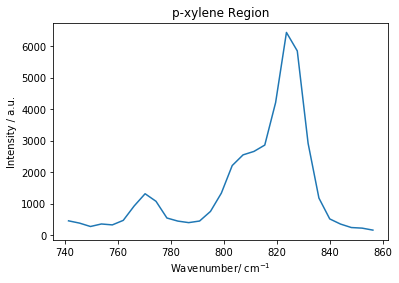

In [3]:
# Extract relevant p-xylene region and Vinyl region from the 1st spectra for
# baseline correction and plot tests.

pxyl_Region = df.iloc[0, 151:180] # Extract 1st spectra at the pxyl region and plot.
pxyl_Region.index = pxyl_Region.index.astype(float) # Change the index type to float.
pxyl_Region.plot()
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region')
plt.show()

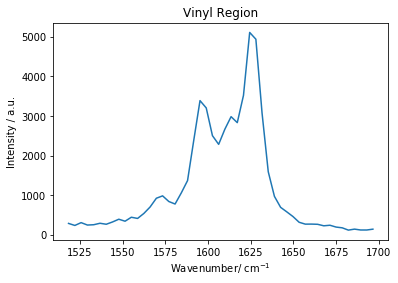

In [4]:
Vinyl_Region = df.iloc[0, 350:400] # Extract 1st spectra at the Vinyl region and plot.
Vinyl_Region.index = Vinyl_Region.index.astype(float) # Change the index type to float.
Vinyl_Region.plot()
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinyl Region')
plt.show()

# Baseline Subtraction

## Custom

Choose two regions on the spectrum that you want to form the basis for the baseline. The spectrum is based on the truncated region of interest from the raw spectrum.

Choose from the curve above, <10 and >50 to form the x and y values to fit a polynomial line, serving as my baseline values. **Note that the x-axis is the placeholder index location of the truncated spectra, not the actual wavenumbers themselves**

p-xylene Region Baseline Subtraction

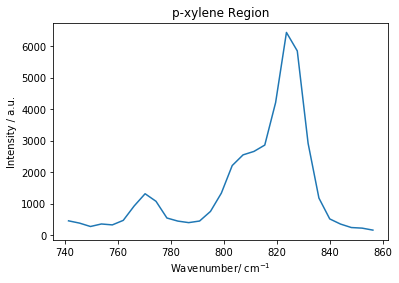

In [5]:
# p-xylene Region Baseline Subtraction
y = df.iloc[0, 151:180]
y.index = y.index.astype('float')
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region')
y.plot()
plt.show()

# y is a Series. A pandas Series is a lablled/ indexed 1-D array. Therefore, a single argument of y,
# itself containing the intensity value (y-axis) at the corresponding wavenumber (x-axis) can be plotted. 

# Plot the 1st spectra (1st row) of df_t0.

In [6]:
xbl = [] # x-baseline.

for items in y.index[:5].values.tolist():
    xbl.append(items)

for items in y.index[25:].values.tolist():
    xbl.append(items)

# Recall that y is a Series with intensities labelled by their wavenumbers. y.index gives the Series labels, which are the 
# wavenumbers. y.index[:10] gives the 0th to 9th Series labels and is an index object. Convert the index object to a numpy
# array via y.index[:10].values, then put them into a list via y.index[:10].values.tolist().

# There are 2 for loops for the xbl (x baseline) list because you want the 1st 10 wavenumbers, but you also want the last
# wavenumbers from index 40 onwards. In the end, xbl is a single list containing all wavenumbers from index 0 to 9,
# and then from index 40 onwards. The same ideas apply for ybl, except for the fact that ybl contains intensities.

ybl = [] # y-baseline.

for items in y.values[:5].tolist():
    ybl.append(items)

for items in y.values[25:].tolist():
    ybl.append(items)
    
# y is a Pandas Series. Therefore, y.values immediately gives the values witihn that series, which are the intensities.

In [7]:
# Check that the range of xbl and ybl values makes sense.
xbl_and_ybl = list(zip(xbl, ybl))# Zip xbl and ybl together, then use list function to unpack the zipped object.
xbl_and_ybl

[(741.346779, 453.0),
 (745.475155, 381.0),
 (749.603622, 273.0),
 (753.730197, 353.0),
 (757.852903, 324.0),
 (843.890025, 350.0),
 (847.959811, 240.0),
 (852.027749, 221.0),
 (856.093841, 158.0)]

Running the baseline fit. **(x-values, y-values, polynomial degree)** are the arguments.

In [8]:
blpars = np.polyfit(xbl, ybl, 1)
# blpars contains the baseline parameters; the coefficients which will allow for the baseline polynomial to be defined.
# Fit a polynomial based on the x and y-values chosen for the spectra during the previous step. Thus, given a list of x values
# and its corresponding y-values, fit a polynomial through these points as best as you can. This polynomial will serve as the 
# baseline to be subtracted from the spectra's y-values. 
# numpy.polyfit(x, y, deg)
# np.polyfit: Least squares polynomial fit. Fit a polynomial p(x) = p[0] * x**deg + ... + p[deg] of degree deg to points (x, y).
# Returns a vector of coefficients p that minimises the squared error in the order deg, deg-1, … 0.
# Since degree = 1, we are fitting a straight line.

blfit = np.poly1d(blpars)
# A one-dimensional polynomial class. A convenience class, used to encapsulate “natural” operations on polynomials so that
# said operations may take on their customary form in code. blfit is a function that encompasses information on blpar's vector
# of coefficients derived from the np.polyfit step. It will take an input of x-values, then apply the coefficients to the
# x-values to obtain the best fit polynomial following the p(x) equation defined above.

Plot showing before and after subtraction.

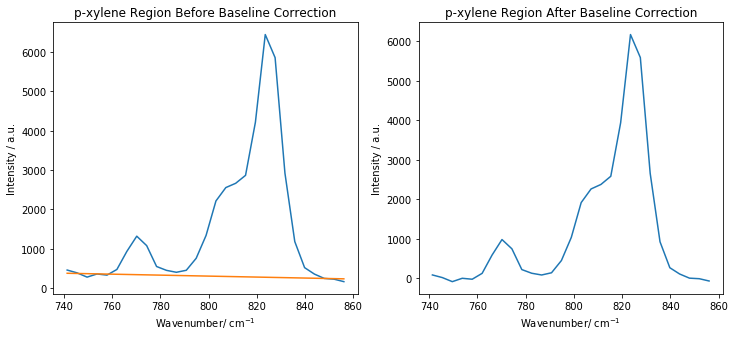

In [9]:
plt.figure(figsize = (12,5))

plt.subplot(1,2,1) # subplot(nrows, ncols, index)
plt.plot(y) # Plot the spectrum using the Series y.
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region Before Baseline Correction')
plt.plot(y.index, blfit(y.index))
# Plot the baseline polynomial to be subtracted (orange color). The x-axis will contain the wavenumbers. 
# Therefore y.index(Series labels) is being plotted at the x-axis. The y-axis will be blfit(y.index) because the output of 
# blfit(y.index) contains the y-values of the polynomial that is best fit to the input x-values.

plt.subplot(1,2,2)
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region After Baseline Correction')
plt.plot(y.index,(y - blfit(y.index)))
# Plot the baseline corrected spectrum. Subtraction can immediately be done because blfit(y.index) is a numpy array of y-values
# of the best fit polynomial. So the each value in Series y will minus each value in array blfit(y.index),
# to yield a final y value, which is the corrected spectra intensity. 

plt.show()

Vinyl Region Baseline Subtraction

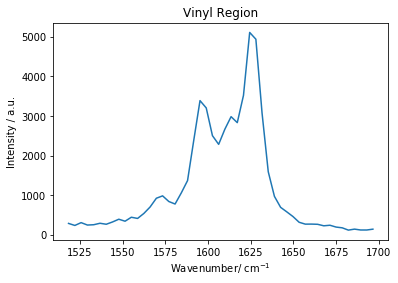

In [10]:
# Vinyl Region Baseline Subtraction
y = df.iloc[0, 350:400]
y.index = y.index.astype('float')
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinyl Region')
y.plot()
plt.show()

In [11]:
xbl = []

for items in y.index[:10].values.tolist():
    xbl.append(items)

for items in y.index[40:].values.tolist():
    xbl.append(items)
    
ybl = []

for items in y.values[:10].tolist():
    ybl.append(items)

for items in y.values[40:].tolist():
    ybl.append(items)

In [12]:
xbl_and_ybl = list(zip(xbl, ybl))
xbl_and_ybl

[(1518.26751, 286.0),
 (1521.955154, 235.0),
 (1525.639408, 306.0),
 (1529.322087, 245.0),
 (1533.003193, 253.0),
 (1536.680916, 290.0),
 (1540.358881, 265.0),
 (1544.033465, 323.0),
 (1547.704672, 392.0),
 (1551.376124, 342.0),
 (1664.14117, 264.0),
 (1667.747082, 226.0),
 (1671.349689, 240.0),
 (1674.952563, 194.0),
 (1678.550353, 175.0),
 (1682.14841, 117.0),
 (1685.743172, 142.0),
 (1689.336421, 120.0),
 (1692.928159, 120.0),
 (1696.518387, 141.0)]

In [13]:
blpars = np.polyfit(xbl, ybl, 1)
blfit = np.poly1d(blpars)

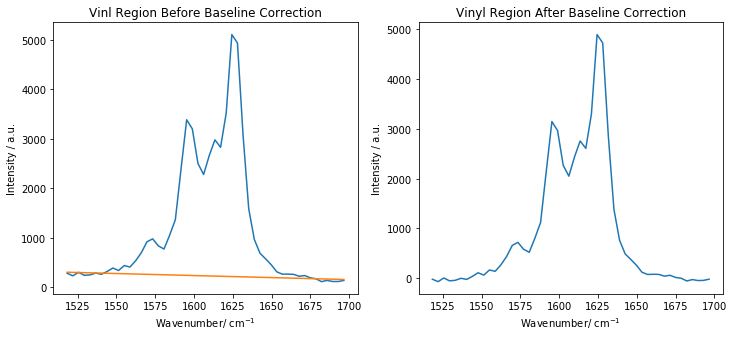

In [14]:
plt.figure(figsize = (12,5))

plt.subplot(1,2,1)
plt.plot(y)
plt.plot(y.index, blfit(y.index))
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinl Region Before Baseline Correction')

plt.subplot(1,2,2)
plt.plot(y.index,(y - blfit(y.index))) 
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinyl Region After Baseline Correction')

plt.show()

# Fitting Functions

In [15]:
from lmfit import Minimizer, Parameters, report_fit
from lmfit.lineshapes import gaussian, lorentzian, split_lorentzian

def residuals(pars,x,y):
    
    model =  (lorentzian(x, pars['ampL1'], pars['cenL1'], pars['widL1']) +
              lorentzian(x, pars['ampL2'], pars['cenL2'], pars['widL2']))
    
    return model - y

# Running Curve Fits

In [16]:
df_vinyl = df.iloc[:, 350:400].copy()
df_vinyl.columns = df_vinyl.columns.astype('float')
df_vinyl

1518.267510  1521.955154  1525.639408  1529.322087  1533.003193  \
0         286.0        235.0        306.0        245.0        253.0   
1         238.0        234.0        358.0        233.0        280.0   
2         226.0        188.0        259.0        207.0        258.0   
3         245.0        166.0        251.0        242.0        277.0   
4         299.0        232.0        263.0        238.0        277.0   
..          ...          ...          ...          ...          ...   
85        426.0        441.0        462.0        446.0        527.0   
86        422.0        473.0        503.0        441.0        507.0   
87        477.0        389.0        473.0        433.0        520.0   
88        389.0        409.0        462.0        464.0        484.0   
89        472.0        433.0        503.0        440.0        586.0   

    1536.680916  1540.358881  1544.033465  1547.704672  1551.376124  ...  \
0         290.0        265.0        323.0        392.0        342.0  ...   
1         321.0        242.0        260.0        391.0        326.0  ...   
2         301.0        261.0        280.0        338.0        313.0  ...   
3         295.0        211.0        309.0        369.0        409.0  ...   
4         278.0        291.0        316.0        398.0        367.0  ...   
..          ...          ...          ...          ...          ...  ...   
85        595.0        561.0        681.0        804.0        739.0  ...   
86        580.0        557.0        697.0        785.0        783.0  ...   
87        638.0        678.0        685.0        754.0        726.0  ...   
88        555.0        564.0        622.0        640.0        805.0  ...   
89        563.0        574.0        651.0        663.0        782.0  ...   

    1664.141170  1667.747082  1671.349689  1674.952563  1678.550353  \
0         264.0        226.0        240.0        194.0        175.0   
1         257.0        279.0        255.0        205.0        186.0   
2         172.0        224.0        198.0        183.0        174.0   
3         197.0        175.0        154.0        132.0        140.0   
4         261.0        199.0        188.0        137.0        216.0   
..          ...          ...          ...          ...          ...   
85        530.0        489.0        433.0        342.0        383.0   
86        544.0        487.0        456.0        368.0        334.0   
87        587.0        482.0        458.0        385.0        418.0   
88        489.0        443.0        411.0        324.0        335.0   
89        482.0        497.0        386.0        386.0        386.0   

    1682.148410  1685.743172  1689.336421  1692.928159  1696.518387  
0         117.0        142.0        120.0        120.0        141.0  
1         101.0        146.0        104.0         99.0        123.0  
2         114.0        118.0        124.0         62.0        111.0  
3         131.0        137.0        128.0         84.0         93.0  
4          97.0        118.0        143.0        167.0        146.0  
..          ...          ...          ...          ...          ...  
85        273.0        283.0        231.0        236.0        337.0  
86        263.0        233.0        242.0        246.0        316.0  
87        231.0        272.0        277.0        182.0        261.0  
88        239.0        227.0        217.0        202.0        282.0  
89        268.0        257.0        217.0        234.0        306.0  

[90 rows x 50 columns]

For 2 Lorentzians peak fits within the region of interest:

## Select initial guess parameters, namely amplitude, centre, width of the peaks.

In [17]:
ampL1 = 140000 # Peak Amplitude of 1st Peak
cenL1 = 1599 # Peak location of 1st Peak
widL1 = 8

ampL2 = 180000 # Peak Amplitude of 2nd Peak
cenL2 = 1627 # Peak location of 2nd Peak
widL2 = 5

## Fitting and Plotting (Vinyl Region)

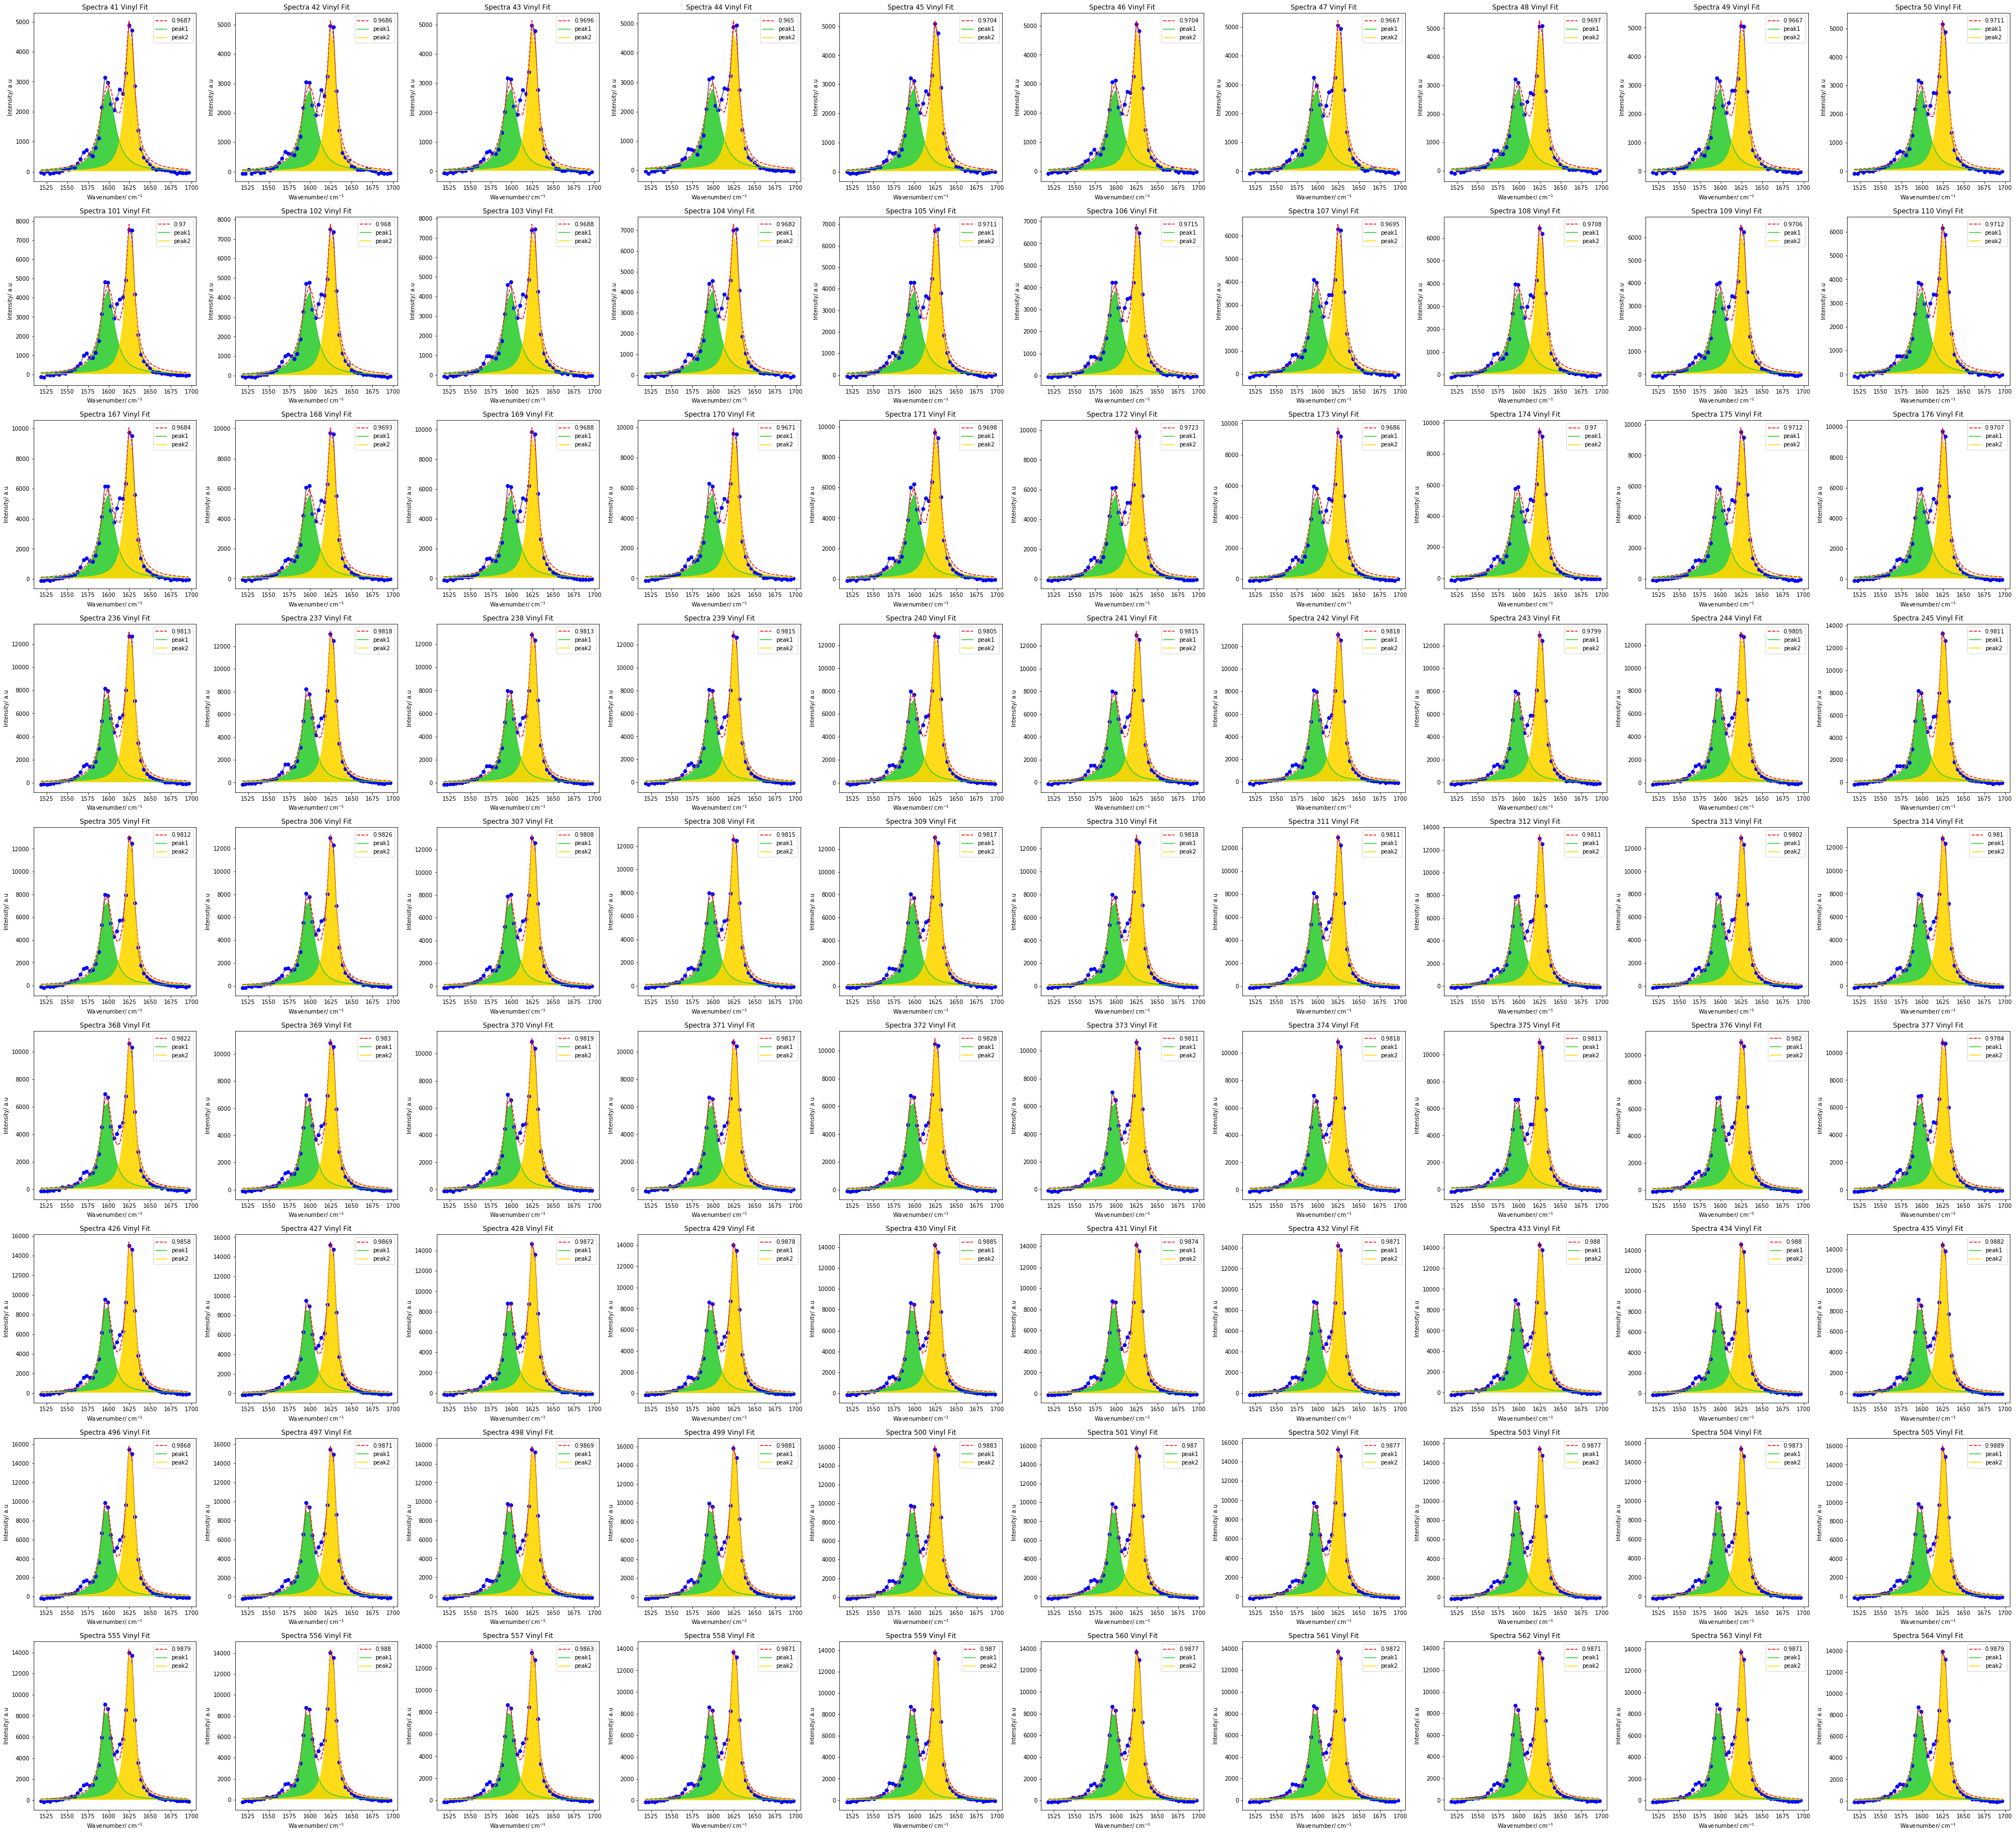

In [18]:
de = collections.deque([])
Area_1 = collections.deque([])
Area_2 = collections.deque([])

pbar = tqdm(total = len(df_vinyl), dynamic_ncols  = True, desc = 'Fitting curves')

plt.figure(figsize = (50,50))

pfit = Parameters()
pfit.add(name='ampL1', value = ampL1, min = 0)
pfit.add(name='ampL2', value = ampL2, min = 0)
pfit.add(name='cenL1', value = cenL1, max = 1605)
pfit.add(name='cenL2', value = cenL2, min = 1620, max = 1640)
pfit.add(name='widL1', value = widL1, min = 0)
pfit.add(name='widL2', value = widL2, min = 0)

for i,item in df_vinyl.iterrows():
    
    x = df_vinyl.columns # Wavenumbers
    
    y = item # Intensities
    
    xbl = []

    for items in y.index[:10].values.tolist():
        xbl.append(items)

    for items in y.index[40:].values.tolist():
        xbl.append(items)


    ybl = []

    for items in y.values[:10].tolist():
        ybl.append(items)

    for items in y.values[40:].tolist():
        ybl.append(items)
    
    blpars = np.polyfit(xbl, ybl, 1)
    blfit = np.poly1d(blpars)
    
    y -= blfit(x) # Corrected Intensities

    mini = Minimizer(residuals, pfit, fcn_args=(x, y))
    out = mini.leastsq()
    best_fit = y + out.residual
    
    fit_params = out.params.valuesdict()
    fit_params['R2'] = r2_score(y,best_fit)
    fit_params['FWHM_L1'] = 2*out.params.valuesdict()['widL1']
    fit_params['FWHM_L2'] = 2*out.params.valuesdict()['widL2']
    fit_params['Height_L1'] = 0.3183099*out.params.valuesdict()['ampL1']/max(2.220446049250313e-16, out.params.valuesdict()['widL1'])
    fit_params['Height_L2'] = 0.3183099*out.params.valuesdict()['ampL2']/max(2.220446049250313e-16, out.params.valuesdict()['widL2'])
    
    
    results = de.append(fit_params)
    
    peak1 = lorentzian(x,out.params.valuesdict()['ampL1'], out.params.valuesdict()['cenL1'], out.params.valuesdict()['widL1'])
    peak2 = lorentzian(x,out.params.valuesdict()['ampL2'], out.params.valuesdict()['cenL2'], out.params.valuesdict()['widL2'])
    
    plt.subplot(np.ceil(np.sqrt(df_vinyl.shape[0])),np.ceil(np.sqrt(df_vinyl.shape[0])),(1+i))
    plt.title('Spectra ' + str(df.loc[i, 'Original Index']) + ' Vinyl Fit')
    plt.xlabel('Wavenumber/ cm$^{-1}$')
    plt.ylabel('Intensity/ a.u')
    plt.plot(x, y, '#606060')
    plt.plot(x, y, 'bo')
    plt.plot(x, best_fit, 'r--', label = str(fit_params['R2'].round(decimals = 4)))
    plt.plot(x, peak1,'#32CD32', label = 'peak1')
    plt.fill_between(x, peak1.min(), peak1, facecolor = '#32CD32', alpha = 0.9)
    plt.plot(x, peak2,'#FFD700', label = 'peak2')
    plt.fill_between(x, peak2.min(), peak2, facecolor = '#FFD700', alpha = 0.9)
    plt.legend(loc='best')
   
    Area_1.append(integrate.simps(peak1, x)) 
    Area_2.append(integrate.simps(peak2, x))
    
    pbar.update(1)
    
pbar.close()
    
plt.tight_layout()
plt.show()

In [19]:
results = pd.DataFrame(de)
results.rename(columns={'R2':'R2_Vinyl'}, inplace=True)
results.describe()

ampL1          ampL2        cenL1        cenL2      widL1  \
count      90.000000      90.000000    90.000000    90.000000  90.000000   
mean   175330.185290  210695.443586  1597.697657  1625.697913   8.745980   
std     39997.205693   61177.813466     0.642416     0.088857   1.199514   
min     88221.518893   91261.525609  1596.893629  1625.403313   7.329950   
25%    165621.958846  178611.876346  1597.102653  1625.655118   7.622311   
50%    194558.056291  240405.209058  1597.514851  1625.706756   8.316744   
75%    200507.985452  253627.707822  1598.421220  1625.756161  10.154744   
max    224012.169068  290144.435124  1599.082599  1625.836278  11.268066   

           widL2   R2_Vinyl    FWHM_L1    FWHM_L2    Height_L1     Height_L2  
count  90.000000  90.000000  90.000000  90.000000    90.000000     90.000000  
mean    5.827793   0.979416  17.491960  11.655586  6649.106245  11615.711621  
std     0.199536   0.007618   2.399028   0.399072  2122.302615   3631.994628  
min     5.519505   0.964955  14.659900  11.039010  2725.496466   4803.064142  
25%     5.654657   0.970739  15.244622  11.309314  5317.598017   9457.041751  
50%     5.813916   0.981392  16.633487  11.627831  7440.911005  13168.916003  
75%     5.991024   0.987069  20.309487  11.982049  8361.968654  14421.737045  
max     6.395305   0.988872  22.536132  12.790609  9572.794442  16424.000777

For 2 Lorentzians peak fits within the region of interest:

In [20]:
Area_2 = pd.Series(Area_2)
labels = df.iloc[:, 0:2]
df_area = pd.concat([labels, Area_2, results['R2_Vinyl']], axis=1)
df_area.rename(columns={0: 'Vinyl Peak Area'}, inplace=True)
df_area

Original Index  Condition  Vinyl Peak Area  R2_Vinyl
0               41         19     89738.849585  0.968682
1               42         19     88385.828895  0.968585
2               43         19     93793.946525  0.969590
3               44         19     87225.849104  0.964955
4               45         19     92731.158192  0.970411
..             ...        ...              ...       ...
85             560         27    238391.113038  0.987721
86             561         27    240008.473629  0.987191
87             562         27    239234.994970  0.987118
88             563         27    243508.715985  0.987076
89             564         27    241114.753472  0.987919

[90 rows x 4 columns]

# Fitting and Plotting (p-xylene Region)

In [21]:
df_pxyl = df.iloc[:, 151:180].copy()
df_pxyl.columns = df_pxyl.columns.astype('float')
df_pxyl

741.346779  745.475155  749.603622  753.730197  757.852903  761.973723  \
0        453.0       381.0       273.0       353.0       324.0       468.0   
1        454.0       369.0       257.0       337.0       381.0       492.0   
2        404.0       351.0       289.0       300.0       369.0       529.0   
3        405.0       381.0       287.0       337.0       374.0       473.0   
4        416.0       357.0       204.0       294.0       363.0       479.0   
..         ...         ...         ...         ...         ...         ...   
85       650.0       602.0       535.0       661.0       790.0      1234.0   
86       668.0       522.0       568.0       650.0       850.0      1116.0   
87       622.0       626.0       501.0       655.0       760.0      1252.0   
88       662.0       609.0       524.0       602.0       766.0      1175.0   
89       658.0       592.0       499.0       604.0       712.0      1162.0   

    766.092657  770.207731  774.320923  778.432235  ...  819.414738  \
0        926.0      1314.0      1074.0       543.0  ...      4212.0   
1        893.0      1327.0      1049.0       589.0  ...      4164.0   
2        904.0      1261.0       927.0       545.0  ...      4380.0   
3        930.0      1330.0       980.0       615.0  ...      4284.0   
4        939.0      1327.0      1002.0       606.0  ...      4405.0   
..         ...         ...         ...         ...  ...         ...   
85      2235.0      3168.0      2545.0      1438.0  ...      5459.0   
86      2225.0      3278.0      2593.0      1395.0  ...      5318.0   
87      2227.0      3236.0      2558.0      1365.0  ...      5330.0   
88      2174.0      3144.0      2600.0      1359.0  ...      5434.0   
89      2128.0      3357.0      2510.0      1391.0  ...      5583.0   

    823.497610  827.580590  831.661712  835.740978  839.816427  843.890025  \
0       6441.0      5854.0      2917.0      1177.0       514.0       350.0   
1       6719.0      5918.0      2844.0      1146.0       517.0       346.0   
2       6696.0      5773.0      2814.0      1162.0       505.0       329.0   
3       6416.0      5700.0      3004.0      1117.0       583.0       320.0   
4       6441.0      5921.0      2972.0      1140.0       453.0       359.0   
..         ...         ...         ...         ...         ...         ...   
85      8302.0      7097.0      3524.0      1617.0       812.0       602.0   
86      8244.0      7091.0      3649.0      1521.0       811.0       584.0   
87      8244.0      7368.0      3636.0      1521.0       761.0       595.0   
88      8446.0      7340.0      3634.0      1587.0       858.0       615.0   
89      8298.0      7240.0      3701.0      1572.0       815.0       574.0   

    847.959811  852.027749  856.093841  
0        240.0       221.0       158.0  
1        245.0       248.0       177.0  
2        167.0       177.0       185.0  
3        241.0       204.0       225.0  
4        247.0       236.0       172.0  
..         ...         ...         ...  
85       510.0       398.0       438.0  
86       447.0       370.0       420.0  
87       438.0       441.0       348.0  
88       437.0       398.0       392.0  
89       427.0       393.0       379.0  

[90 rows x 29 columns]

In [22]:
def residuals(pars,x,y):
    
    model =  (lorentzian(x, pars['ampL1'], pars['cenL1'], pars['widL1']) +
              lorentzian(x, pars['ampL2'], pars['cenL2'], pars['widL2']) +
              split_lorentzian(x, pars['ampL3'], pars['cenL3'], pars['widL3'],pars['widL4']))
    
    return model - y

In [23]:
ampL1 = 20000
cenL1 = 772 
widL1 = 3

ampL2 = 25000 
cenL2 = 808
widL2 = 5

ampL3 = 100000
cenL3 = 826
widL3 = 6
widL4 = 4

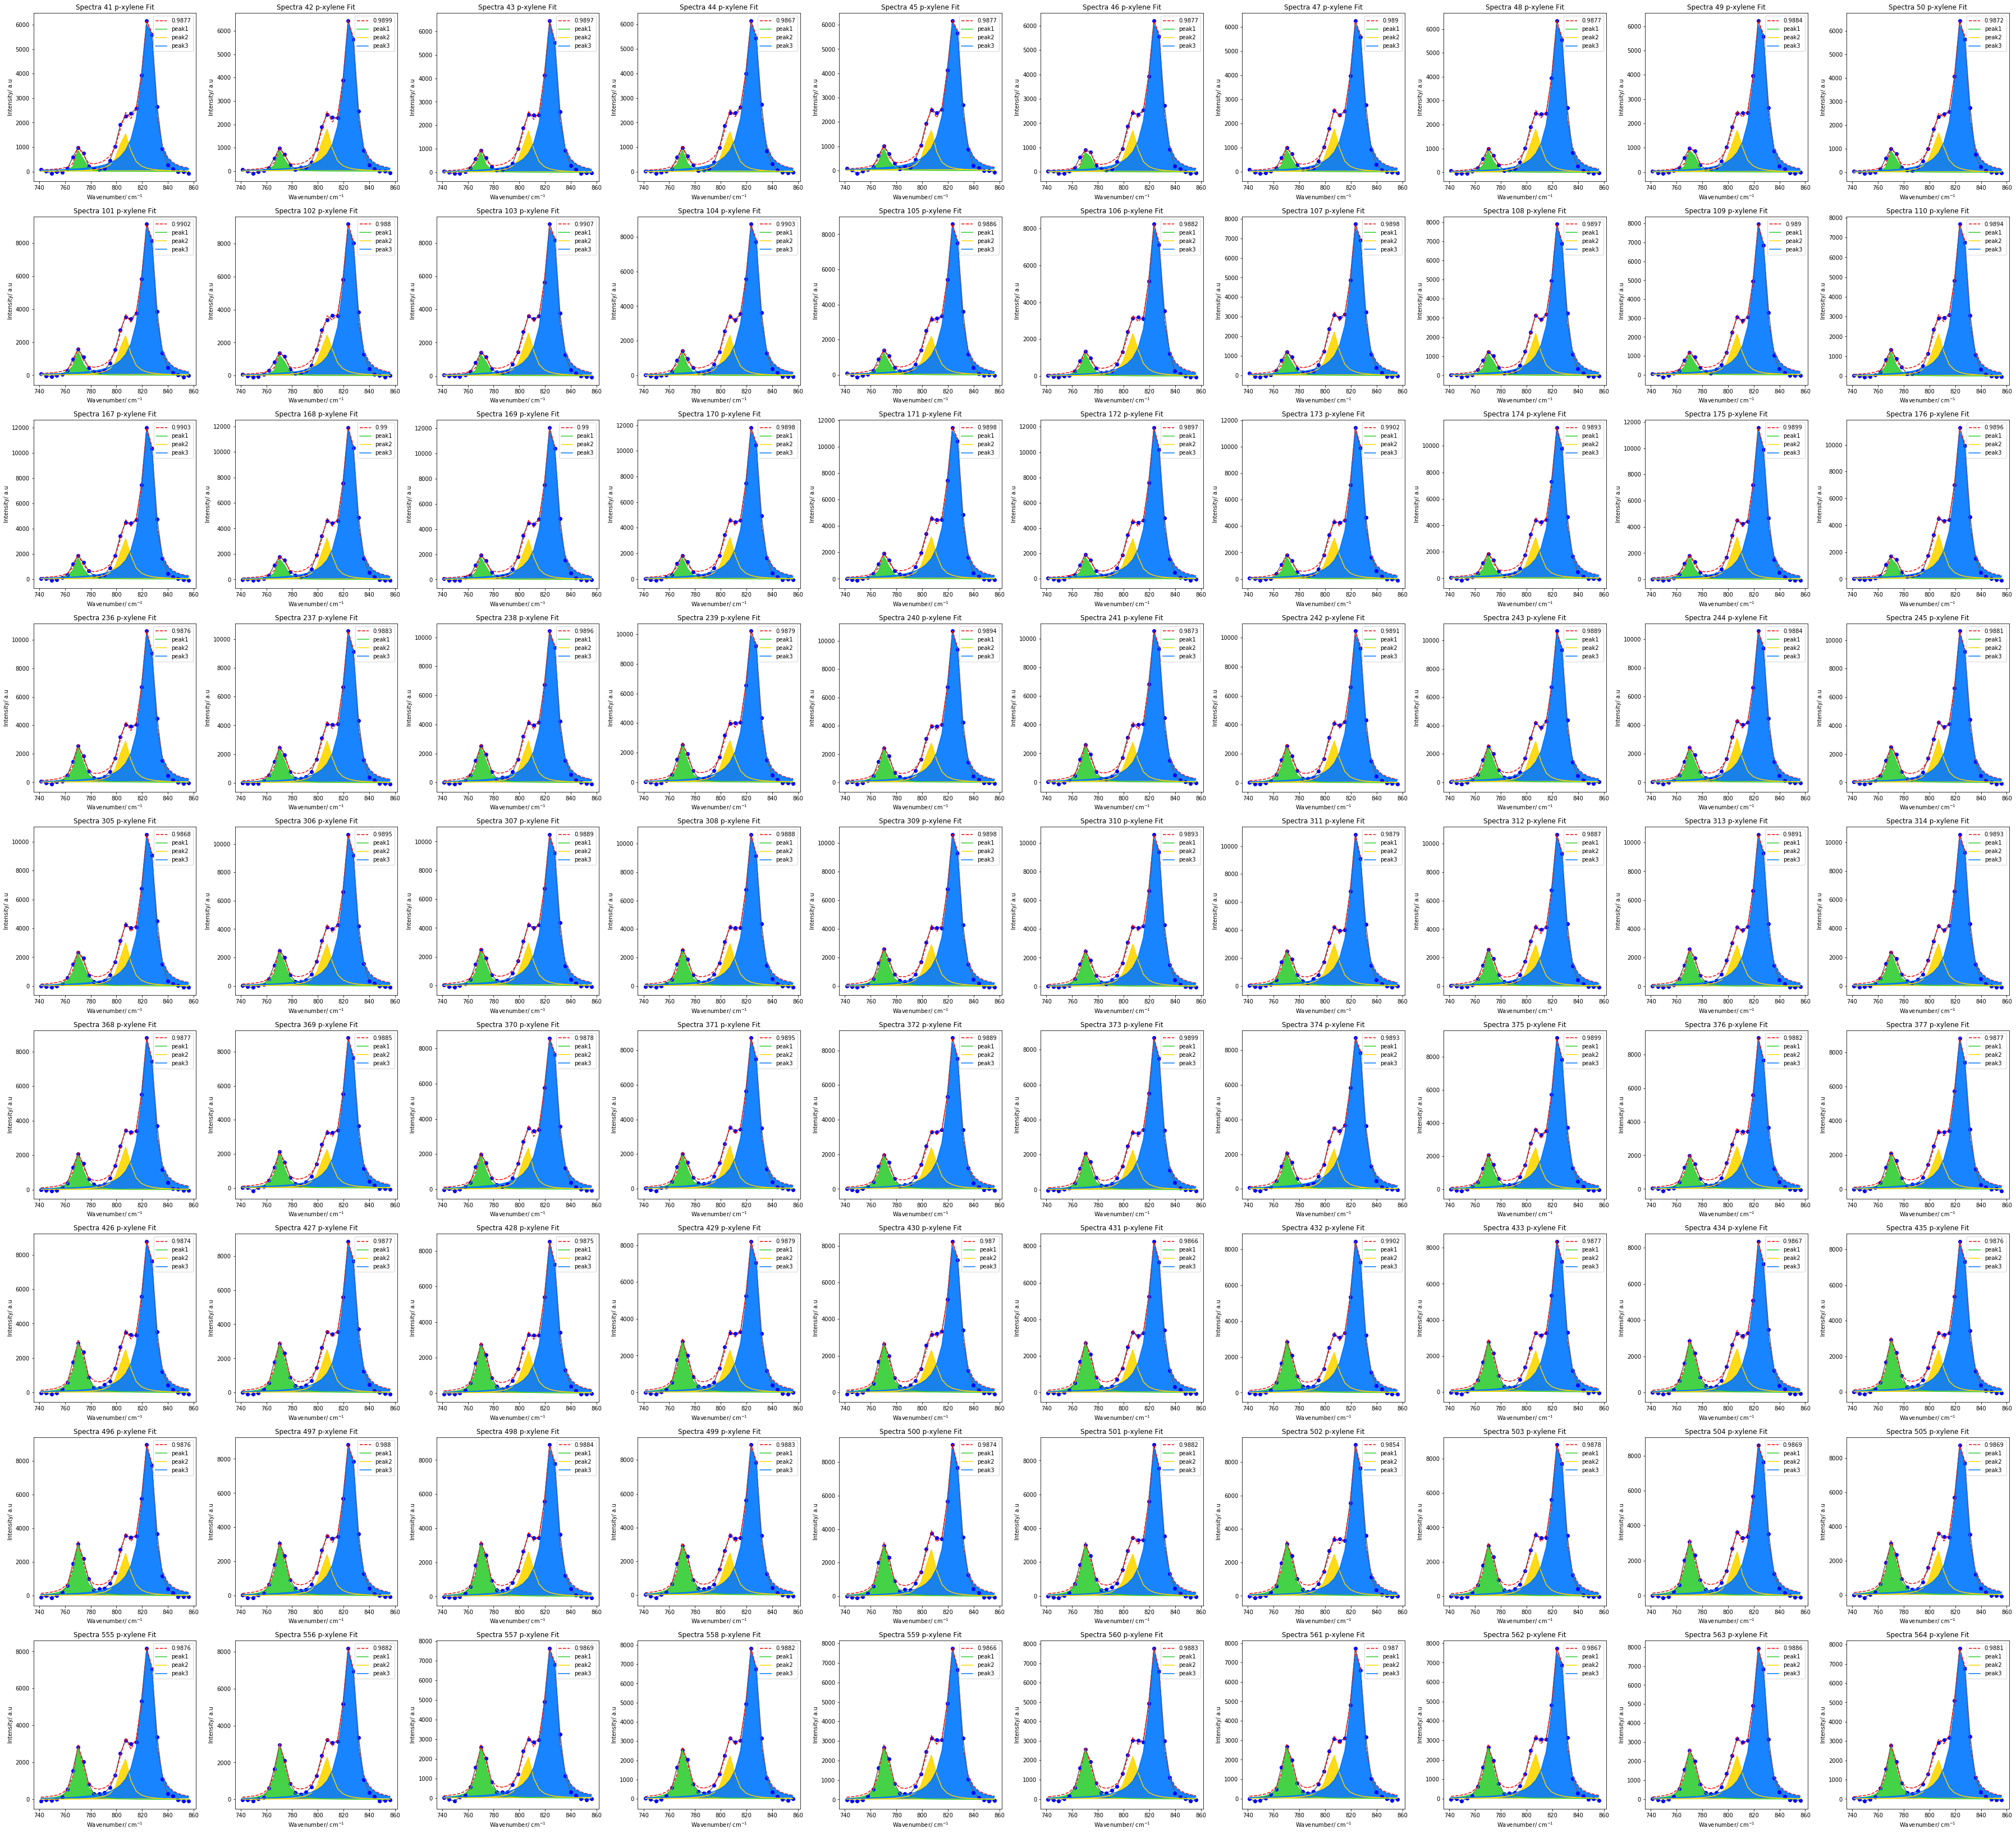

In [24]:
de = collections.deque([])
Area_1 = collections.deque([])
Area_2 = collections.deque([])
Area_3 = collections.deque([])

pbar = tqdm(total = len(df_pxyl), dynamic_ncols  = True, desc = 'Fitting curves')

plt.figure(figsize = (50,50))

pfit = Parameters()
pfit.add(name='ampL1', value = ampL1, min = 0)
pfit.add(name='ampL2', value = ampL2, min = 0)
pfit.add(name='ampL3', value = ampL3, min = 0)
pfit.add(name='cenL1', value = cenL1, min = 770, max = 780)
pfit.add(name='cenL2', value = cenL2, min = 805, max = 815)
pfit.add(name='cenL3', value = cenL3, min = 820, max = 830)
pfit.add(name='widL1', value = widL1, min = 0)
pfit.add(name='widL2', value = widL2, min = 0)
pfit.add(name='widL3', value = widL3, min = 0)
pfit.add(name='widL4', value = widL4, min = 0)

for i,item in df_pxyl.iterrows():
    
    x = df_pxyl.columns # Wavenumbers
    
    y = item # Intensities
    
    xbl = []

    for items in y.index[:5].values.tolist():
        xbl.append(items)

    for items in y.index[25:].values.tolist():
        xbl.append(items)


    ybl = []

    for items in y.values[:5].tolist():
        ybl.append(items)

    for items in y.values[25:].tolist():
        ybl.append(items)
    
    blpars = np.polyfit(xbl, ybl, 1)
    blfit = np.poly1d(blpars)
    
    y -= blfit(x) # Corrected Intensities

    mini = Minimizer(residuals, pfit, fcn_args=(x, y))
    out = mini.leastsq()
    best_fit = y + out.residual
    
    fit_params = out.params.valuesdict()
    fit_params['R2'] = r2_score(y,best_fit)
    fit_params['FWHM_L1'] = 2*out.params.valuesdict()['widL1']
    fit_params['FWHM_L2'] = 2*out.params.valuesdict()['widL2']
    fit_params['FWHM_L3'] = out.params.valuesdict()['widL3'] + out.params.valuesdict()['widL4']
    fit_params['Height_L1'] = 0.318309886*out.params.valuesdict()['ampL1']/max(2.220446049250313e-16, out.params.valuesdict()['widL1'])
    fit_params['Height_L2'] = 0.318309886*out.params.valuesdict()['ampL2']/max(2.220446049250313e-16, out.params.valuesdict()['widL2'])
    fit_params['Height_L3'] = 0.318309886*out.params.valuesdict()['ampL3']/max(2.220446049250313e-16, out.params.valuesdict()['widL3']+out.params.valuesdict()['widL4'])
    
    results = de.append(fit_params)
    
    peak1 = lorentzian(x,out.params.valuesdict()['ampL1'], out.params.valuesdict()['cenL1'], out.params.valuesdict()['widL1'])
    peak2 = lorentzian(x,out.params.valuesdict()['ampL2'], out.params.valuesdict()['cenL2'], out.params.valuesdict()['widL2'])
    peak3 = split_lorentzian(x,out.params.valuesdict()['ampL3'], out.params.valuesdict()['cenL3'], out.params.valuesdict()['widL3'], out.params.valuesdict()['widL4'])
    
    plt.subplot(np.ceil(np.sqrt(df_pxyl.shape[0])),np.ceil(np.sqrt(df_pxyl.shape[0])),(1+i))
    plt.title('Spectra ' + str(df.loc[i, 'Original Index']) + ' p-xylene Fit')
    plt.xlabel('Wavenumber/ cm$^{-1}$')
    plt.ylabel('Intensity/ a.u')
    plt.plot(x, y, '#606060')
    plt.plot(x, y, 'bo')
    plt.plot(x, best_fit, 'r--', label = str(fit_params['R2'].round(decimals = 4)))
    plt.plot(x, peak1,'#32CD32', label = 'peak1')
    plt.fill_between(x, peak1.min(), peak1, facecolor = '#32CD32', alpha = 0.9)
    plt.plot(x, peak2,'#FFD700', label = 'peak2')
    plt.fill_between(x, peak2.min(), peak2, facecolor = '#FFD700', alpha = 0.9)
    plt.plot(x, peak3,'#0077FF', label = 'peak3')
    plt.fill_between(x, peak3.min(), peak3, facecolor = '#0077FF', alpha = 0.9)
    plt.legend(loc='best')
   
    Area_1.append(integrate.simps(peak1, x)) 
    Area_2.append(integrate.simps(peak2, x))
    Area_3.append(integrate.simps(peak3, x))
    
    pbar.update(1)
    
plt.tight_layout()
plt.show()

In [25]:
results = pd.DataFrame(de)
results.rename(columns={'R2':'R2_pxyl'}, inplace=True)
results.describe()

ampL1         ampL2          ampL3       cenL1       cenL2  \
count     90.000000     90.000000      90.000000   90.000000   90.000000   
mean   26865.720165  40191.688311  166170.620264  770.967126  806.729691   
std    10255.599076   6983.984245   28625.337989    0.343906    0.211663   
min     8861.602681  24658.017730  113751.660102  770.000000  806.164207   
25%    19268.241684  35892.886402  147924.055667  770.741302  806.630015   
50%    29815.747281  39617.230813  160586.601069  770.970359  806.759872   
75%    35282.754414  46430.571216  193675.673909  771.117776  806.831646   
max    42497.769704  52718.899506  218666.638261  771.917197  807.161552   

            cenL3      widL1      widL2      widL3      widL4    R2_pxyl  \
count   90.000000  90.000000  90.000000  90.000000  90.000000  90.000000   
mean   825.601387   3.773565   5.077521   6.818771   4.139020   0.988465   
std      0.090105   0.449656   0.226467   0.220333   0.075308   0.001134   
min    825.404003   2.525282   4.518255   6.344321   3.965347   0.985365   
25%    825.540627   3.543884   4.960677   6.677141   4.091275   0.987659   
50%    825.602762   3.883568   5.066838   6.799207   4.130415   0.988338   
75%    825.663996   4.122639   5.218193   6.907127   4.180823   0.989485   
max    825.859413   4.368494   5.696168   7.552535   4.338600   0.990697   

         FWHM_L1    FWHM_L2    FWHM_L3    Height_L1    Height_L2    Height_L3  
count  90.000000  90.000000  90.000000    90.000000    90.000000    90.000000  
mean    7.547130  10.155041  10.957791  2203.051707  2521.246839  4830.430711  
std     0.899312   0.452934   0.244012   678.504591   434.761565   841.944344  
min     5.050564   9.036510  10.387737   848.422689  1569.546412  3254.166843  
25%     7.087769   9.921354  10.820352  1717.661144  2285.589704  4335.762684  
50%     7.767135  10.133677  10.933361  2444.588256  2479.110664  4692.647120  
75%     8.245279  10.436385  11.068708  2724.102074  2920.845329  5632.340421  
max     8.736989  11.392336  11.716205  3214.361448  3296.854245  6415.581497

In [26]:
df_area = pd.concat([df_area, pd.Series(Area_3), results['R2_pxyl']], axis=1)
df_area.rename(columns={0: 'pxyl Peak Area'}, inplace=True)
df_area

Original Index  Condition  Vinyl Peak Area  R2_Vinyl  pxyl Peak Area  \
0               41         19     89738.849585  0.968682   111310.927344   
1               42         19     88385.828895  0.968585   106791.129538   
2               43         19     93793.946525  0.969590   110018.273620   
3               44         19     87225.849104  0.964955   111221.823660   
4               45         19     92731.158192  0.970411   114628.701165   
..             ...        ...              ...       ...             ...   
85             560         27    238391.113038  0.987721   128829.475878   
86             561         27    240008.473629  0.987191   129960.353938   
87             562         27    239234.994970  0.987118   130938.394383   
88             563         27    243508.715985  0.987076   132668.395064   
89             564         27    241114.753472  0.987919   136075.121692   

     R2_pxyl  
0   0.987663  
1   0.989928  
2   0.989671  
3   0.986669  
4   0.987670  
..       ...  
85  0.988344  
86  0.987029  
87  0.986685  
88  0.988610  
89  0.988074  

[90 rows x 6 columns]

In [27]:
# Keep only columns with R2 values above a threshold.
df_area = df_area[(df_area['R2_Vinyl'] > 0.96) & (df_area['R2_pxyl'] > 0.96)]

# Normalization
df_area['Vinyl Divide pxyl'] =  df_area['Vinyl Peak Area'] / df_area['pxyl Peak Area']

df_area

Original Index  Condition  Vinyl Peak Area  R2_Vinyl  pxyl Peak Area  \
0               41         19     89738.849585  0.968682   111310.927344   
1               42         19     88385.828895  0.968585   106791.129538   
2               43         19     93793.946525  0.969590   110018.273620   
3               44         19     87225.849104  0.964955   111221.823660   
4               45         19     92731.158192  0.970411   114628.701165   
..             ...        ...              ...       ...             ...   
85             560         27    238391.113038  0.987721   128829.475878   
86             561         27    240008.473629  0.987191   129960.353938   
87             562         27    239234.994970  0.987118   130938.394383   
88             563         27    243508.715985  0.987076   132668.395064   
89             564         27    241114.753472  0.987919   136075.121692   

     R2_pxyl  Vinyl Divide pxyl  
0   0.987663           0.806200  
1   0.989928           0.827651  
2   0.989671           0.852531  
3   0.986669           0.784251  
4   0.987670           0.808970  
..       ...                ...  
85  0.988344           1.850439  
86  0.987029           1.846782  
87  0.986685           1.827081  
88  0.988610           1.835469  
89  0.988074           1.771924  

[90 rows x 7 columns]

In [28]:
# View the summary statistics
df_area_stats = df_area[['Condition', 'Vinyl Divide pxyl']].groupby('Condition').describe()
df_area_stats

Vinyl Divide pxyl                                                    \
                      count      mean       std       min       25%       50%   
Condition                                                                       
19                     10.0  0.826025  0.020582  0.784251  0.813640  0.830231   
20                     10.0  0.848271  0.019530  0.818892  0.837422  0.847064   
21                     10.0  0.868751  0.012153  0.850907  0.860240  0.867857   
22                     10.0  1.271285  0.019800  1.240887  1.258886  1.271459   
23                     10.0  1.267293  0.010178  1.252177  1.263345  1.266176   
24                     10.0  1.276951  0.042337  1.197488  1.251279  1.283732   
25                     10.0  1.768109  0.029243  1.732012  1.745325  1.759346   
26                     10.0  1.814734  0.033413  1.766135  1.791113  1.804584   
27                     10.0  1.802577  0.041326  1.722643  1.776223  1.809316   

                               
                75%       max  
Condition                      
19         0.840268  0.852531  
20         0.860706  0.882485  
21         0.876844  0.890138  
22         1.288534  1.296134  
23         1.271955  1.285434  
24         1.302500  1.334001  
25         1.787091  1.824881  
26         1.842711  1.868155  
27         1.833372  1.850439

In [29]:
mean = df_area_stats['Vinyl Divide pxyl', 'mean'].values
std = df_area_stats['Vinyl Divide pxyl', 'std'].values
condition = range(19,28)

In [30]:
df_ratio = pd.DataFrame({'Condition':condition, 'Mean Ratio':mean, 'Standard Deviation': std})
df_ratio

Condition  Mean Ratio  Standard Deviation
0         19    0.826025            0.020582
1         20    0.848271            0.019530
2         21    0.868751            0.012153
3         22    1.271285            0.019800
4         23    1.267293            0.010178
5         24    1.276951            0.042337
6         25    1.768109            0.029243
7         26    1.814734            0.033413
8         27    1.802577            0.041326

In [31]:
df_ratio.to_csv(r'C:\Users\Tan Jin Da\Desktop\High Throughput Experiments Data\201022 High Throughput Experiment Conditions 19 to 27\Online Raman\df_t60_ratio.csv')